This notebook contains the code and instructions to run Metadynamics Deep Potential Molecular Dynamics simualtions (DPMD) with the trained models of butane using all the datasets and classical (CLC) and Ab initio single point calculation (SPC).

The main idea of this runs is to analyze the dihedral samples of butane during the metadynamics DPMD simulation and compare the Free energy surface results with the reference. The main simulation script is 'Butane_Metadym_DPMD.in'. This file contains importat simulation settings such as the temperature, timestep, siumulation time, and force field to be used. Inside this file you will find a commented par_coeff options that can be uncommented to use any of the trained forcefield for the simulations. The plumed input file (plumed_but.dat), now contain parameter to perform metadynamics simulations.

For porposes of this tutorial we will keep working with the butane model Trained with the Boltzmann distribution and the ab initio level of theory, but the same approach will work for any of the other models. Change name of the title of the plot accordingly. 

In [19]:
#  imports
import plumed
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error


In [2]:
## Run the code bellow to sum the hills of the metadynamics simualtions 
## Obtain the FES from the HILLS file. In some cases it might be required to run directly from terminal.

# os.system('plumed sum_hills --hills HILLS --stride 1000 --mintozero')

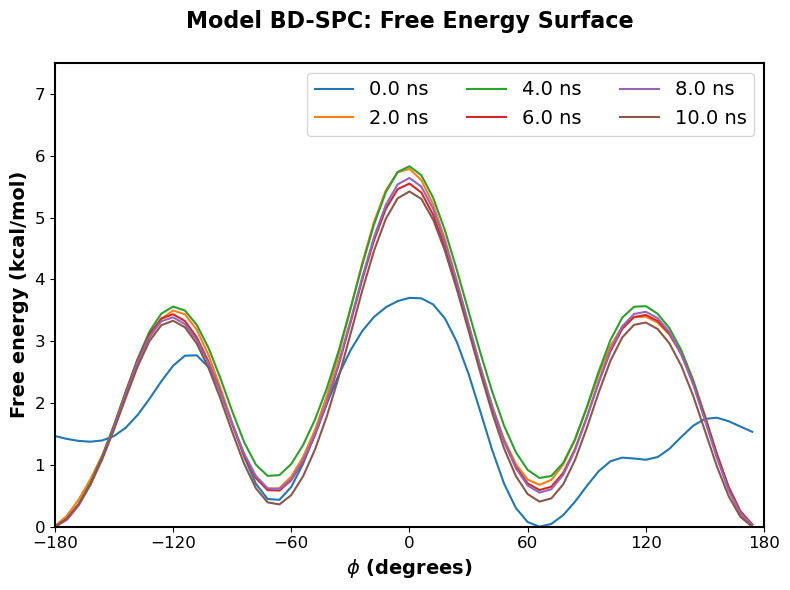

In [10]:
## PLot the FES at different times to see how it changes 

fes_files = glob.glob("fes_*.dat")
fes_files = len(fes_files)
converge_every = 40

plt.figure(figsize=(8,6))
# plot free energy as a function of simulation time
for i in range(0,fes_files,converge_every):   
    # import fes file into pandas dataset
    data=plumed.read_as_pandas("fes_"+str(i)+".dat")

    # plot fes
    plt.plot(np.rad2deg(data["phi"]),data["file.free"]*0.239, label=str(i/20)+" ns") 
# labels
plt.title("Model BD-SPC: Free Energy Surface\n",fontsize=16, fontweight="bold")
plt.xlabel("$\phi$ (degrees)", fontsize=14, fontweight="bold")
plt.ylabel("Free energy (kcal/mol)", fontsize=14, fontweight="bold")
plt.xlim(-180,180)
plt.ylim(0,7.5)
plt.xticks(np.arange(-180, 180+60, step=60))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(ncol=3,fontsize=14)
# Darken the borders of the plot
ax = plt.gca()
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tight_layout()
plt.show()

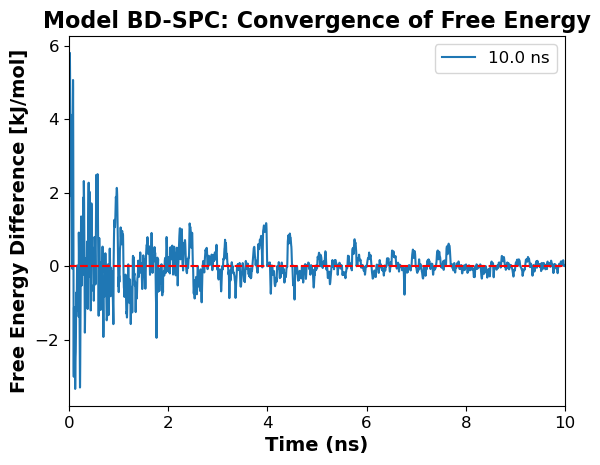

In [11]:
## Define function to calculate and plot convergence of the FES 

# Calculate and plot convergence difference 
def calculate_and_plot_convergence(fes_files, save_cv=False):
    # Array to store the differences
    differences = []

    # Calculate the differences between iterations
    for i in range(0, fes_files, 1):
        # Import fes file into pandas dataset
        data = plumed.read_as_pandas("fes_" + str(i) + ".dat")

        # Calculate the difference between current and past iteration
        if i > 0:
            diff = data["file.free"].values[-60:] - prev_data["file.free"].values[-60:]
            differences.append(diff)

        # Set previous data for the next iteration
        prev_data = data

    # Plot the differences for convergence
    #for i, diff in enumerate(differences):
    plt.plot(np.arange(len(np.array(differences).flatten()))/600 ,np.array(differences).flatten(), label=str(i/20) + " ns")


    # Plot a horizontal line at 0 for reference
    plt.axhline(y=0, color="red", linestyle="--")
    # Labels
    plt.title("Model BD-SPC: Convergence of Free Energy", fontsize=16, fontweight="bold")
    plt.xlabel("Time (ns)", fontsize=14, fontweight="bold")
    plt.ylabel("Free Energy Difference [kJ/mol]", fontsize=14, fontweight="bold")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xlim(0,10)
    plt.legend(ncol=3,fontsize=12)
    
    if save_cv:
        plt.savefig("fes_convergence.png",dpi=300)
    plt.show()
    return differences


# Call the function
dif = calculate_and_plot_convergence(fes_files, save_cv=False)
#np.savetxt("fes_convergence_BD-spc.txt", np.array(dif).flatten())


In [21]:
## Load reference FES to compare 
fes_ref = plumed.read_as_pandas('./fes_AIMD_Metadym_600ps.dat')

In [22]:
# Determine MAE

mae = mean_absolute_error(fes_ref["file.free"]*0.239, data["file.free"]*0.239)

print(f'The MAE between the Bolztmann and Reference distributions is {mae:.2f} kcal/mol')

The MAE between the Bolztmann and Reference distributions is 0.11 kJ/mol


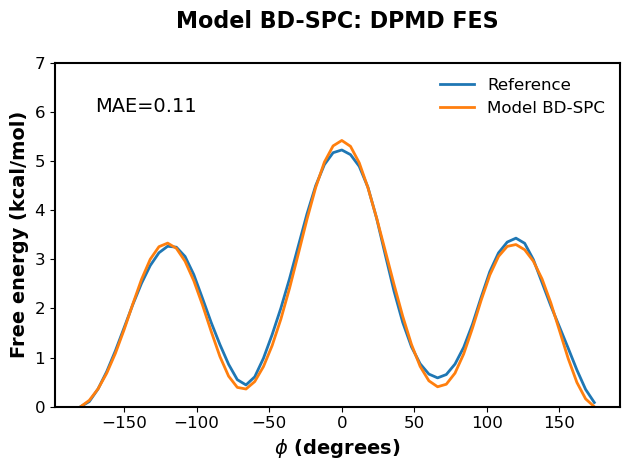

In [27]:
# PLot the FES for the three distributions
plt.plot(np.rad2deg(fes_ref["phi"]), fes_ref["file.free"]*0.239, label="Reference", linewidth=2)
plt.plot(np.rad2deg(data["phi"]),data["file.free"]*0.239, label="Model BD-SPC", linewidth=2)

## Add the MAE as text
## Add 'A' as a label for the reference
plt.text(-170, 6, f'MAE={mae:.2f}', fontsize=14)


# labels
plt.title("Model BD-SPC: DPMD FES\n",fontsize=16, fontweight="bold")
plt.xlabel("$\phi$ (degrees)", fontsize=14, fontweight="bold")
plt.ylabel("Free energy (kcal/mol)", fontsize=14, fontweight="bold")
# plt.xlim(-np.pi,np.pi)
plt.ylim(0,7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(ncol=1, fontsize=12, loc="upper right",frameon=False)


# Bold borders 

ax = plt.gca()
ax.spines["top"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
ax.spines["left"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)
plt.tight_layout()
plt.show()

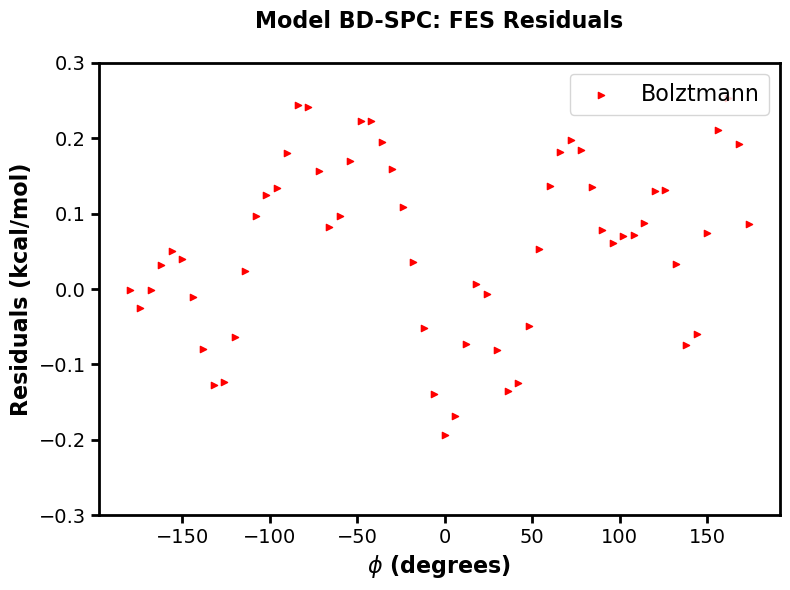

In [29]:
## Calculate and plot residuals 

#  Calculate the residuals between the reference and the Boltzmann distribution

residuals_Boltz = fes_ref["file.free"]*0.239 - data["file.free"]*0.239
plt.figure(figsize=(8,6))
plt.scatter(np.rad2deg(fes_ref["phi"]), residuals_Boltz, label="Bolztmann",s=20,marker=">",color="red")


plt.xlabel("$\phi$ (degrees)",fontsize=16,fontweight="bold")
plt.ylabel("Residuals (kcal/mol)",fontsize=16,fontweight="bold")
plt.title("Model BD-SPC: FES Residuals\n",fontsize=16,fontweight="bold")

ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# increase the tick size
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=6)
plt.legend(loc="upper right",fontsize=16,frameon=True)
plt.tight_layout()
plt.ylim((-0.3,0.3))
plt.show()

